In [1]:
from pathlib import Path
import sys, os
import numpy as np
from pprint import pprint
from copy import deepcopy


# notebook이 examples/selectiveRIP에서 실행 중일 때
repo_root = Path.cwd().resolve().parents[1]  # .../qubit-experiment
sys.path.insert(0, str(repo_root))

In [2]:

from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType
from example_helpers.generate_descriptor import generate_descriptor


descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=3,
    multiplex=True,
    number_multiplex=3,
    include_cr_lines=False,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="withplus",
    ip_address="192.168.0.83"
)




#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:

from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


In [4]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
#from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


In [5]:
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits

fuck
LOADED: ./qpu_parameters/20260116-1729_multiplexing_test


In [6]:
session = Session(setup)
session.connect(do_emulation=False)

[2026.01.16 17:45:36.380] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.01.16 17:45:36.382] INFO    VERSION: laboneq 25.10.3
[2026.01.16 17:45:36.383] INFO    Connecting to data server at 192.168.0.83:8004
[2026.01.16 17:45:36.421] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.01.16 17:45:36.466] INFO    Configuring the device setup
[2026.01.16 17:45:36.504] INFO    The device setup is configured


In [164]:
qubits[0].parameters.readout_integration_delay = 0 #340e-9
qubits[1].parameters.readout_integration_delay = 0
qubits[0].parameters.readout_length = 1.0e-6
qubits[0].parameters.readout_integration_length = 1.0e-6
qubits[1].parameters.readout_length = 1.0e-6
qubits[1].parameters.readout_integration_length = 1.0e-6

In [165]:
qubits[0].parameters.readout_range_out  = 5
qubits[1].parameters.readout_range_out = 5
qubits[0].parameters.readout_range_in = 10
qubits[1].parameters.readout_range_in = 10

In [166]:
qubits[1].parameters.readout_amplitude = 1.0
qubits[0].parameters.readout_amplitude = 1.0

In [167]:
qubits[0].parameters.readout_lo_frequency

7400000000.0

In [168]:
qubits[0].parameters.readout_resonator_frequency = 7.1e9


In [169]:
qubits[1].parameters.readout_resonator_frequency = 7.7e9

In [170]:
@dsl.qubit_experiment
def build_exp(qpu, qubits):
    qop = qpu.quantum_operations
    max_len = qpu.measure_section_length(qubits)

    with dsl.acquire_loop_rt(
        count=12,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.RAW,
    ):
        with dsl.section(name="main_measure", alignment=SectionAlignment.LEFT):
            qop.multiplexed_readout(qubits)

exp = build_exp(qpu, [qubits[0],qubits[1]])

session = Session(setup)
compiled = session.compile(exp)
print("compile ok:", type(compiled))


[2026.01.16 19:04:40.032] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.01.16 19:04:40.034] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'q0/acquire' to SOFTWARE
[2026.01.16 19:04:40.035] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal 'q0/drive' to HARDWARE
[2026.01.16 19:04:40.035] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal 'q0/drive_ef' to HARDWARE
[2026.01.16 19:04:40.036] INFO    Resolved modulation type of oscillator 'q1_readout_acquire_osc' on signal 'q1/acquire' to SOFTWARE
[2026.01.16 19:04:40.036] INFO    Resolved modulation type of oscillator 'q1_drive_ge_osc' on signal 'q1/drive' to HARDWARE
[2026.01.16 19:04:40.037] INFO    Resolved modulation type of oscillator 'q1_drive_ef_osc' on signal 'q1/drive_ef' to HARDWARE
[2026.01.16 19:04:40.038] INFO 

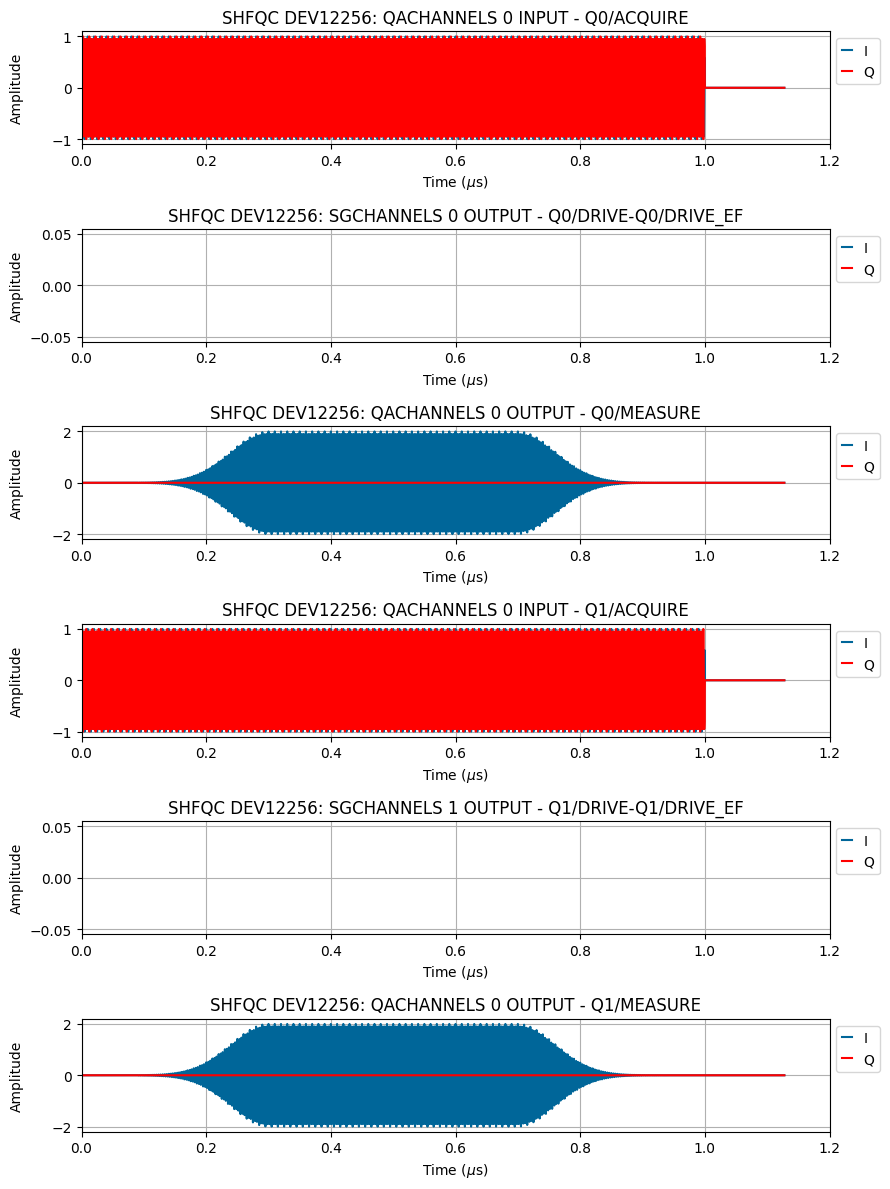

In [171]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=compiled,name='test', interactive=True)
plot_simulation(compiled_experiment=compiled, length=1.2e-6)

In [172]:
# from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
# import time

# t = time.localtime()
# timestamp = time.strftime('%Y%m%d-%H%M', t)

# filename = "multiplexing_test"
# save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}") # 이거 Path로 바꿔야함





# kernel

integration시에 kernel 은 q0,q1,q2에 대해서 다르게 해야함

In [173]:
session = Session(setup)
session.connect()  # 실제 장비
# 또는 session.connect(do_emulation=True)

compiled = session.compile(exp)
results = session.run(compiled)


[2026.01.16 19:04:40.931] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.01.16 19:04:40.933] INFO    VERSION: laboneq 25.10.3
[2026.01.16 19:04:40.934] INFO    Connecting to data server at 192.168.0.83:8004
[2026.01.16 19:04:40.965] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.01.16 19:04:41.007] INFO    Configuring the device setup
[2026.01.16 19:04:41.040] INFO    The device setup is configured
[2026.01.16 19:04:41.566] INFO    Resolved modulation type of oscillator 'q0_readout_acquire_osc' on signal 'q0/acquire' to SOFTWARE
[2026.01.16 19:04:41.567] INFO    Resolved modulation type of oscillator 'q0_drive_ge_osc' on signal 'q0/drive' to HARDWARE
[2026.01.16 19:04:41.567] INFO    Resolved modulation type of oscillator 'q0_drive_ef_osc' on signal 'q0/drive_ef' to HARDWARE
[2026.01.16 19:04:41.56

In [174]:
data = results['q0/result'].data

In [177]:
t

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.997e+03, 1.998e+03,
       1.999e+03], shape=(2000,))

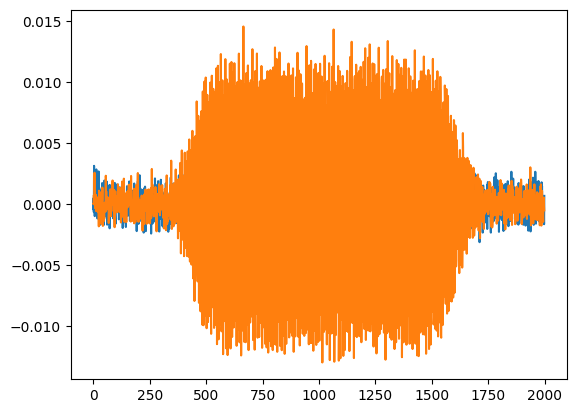

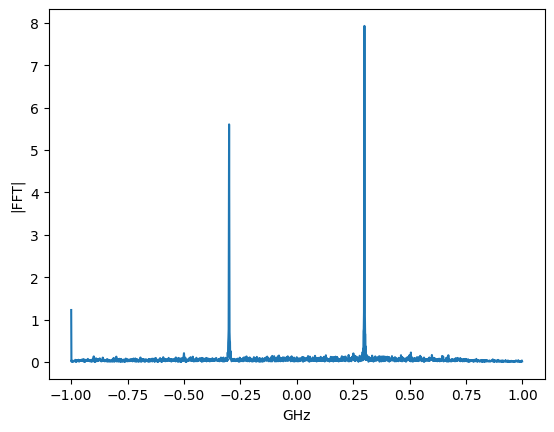

In [183]:
import matplotlib.pyplot as plt
res = results[dsl.handles.result_handle("q0")]  # 아무 handle 하나
raw = res.data
raw_avg = raw.mean(axis=0) #if raw.ndim > 1 else raw

# 시간축 있으면 사용, 없으면 샘플 인덱스
t = res.axis[1] #if res.axis else np.arange(raw_avg.size)
dt = (t[1] - t[0])/2

# DC 제거 + window (leakage 완화)
#raw_avg = raw_avg - raw_avg.mean()
#win = np.hanning(raw_avg.size)

# time trace
plt.plot(t, raw_avg.real)
plt.plot(t, raw_avg.imag)

# FFT (양/음 주파수 모두 보기)
freq = np.fft.fftfreq(raw_avg.size, d=dt)
spec = np.fft.fft(raw_avg )
freq = np.fft.fftshift(freq)
spec = np.fft.fftshift(spec)

#mask = (freq > 0) & (freq < 0.1)


plt.figure()
#plt.plot(freq[mask] , np.abs(spec)[mask])
plt.plot(freq , np.abs(spec))
plt.xlabel("GHz")
plt.ylabel("|FFT|")
#plt.xlim(-300, 300)
plt.show()

In [179]:
readout_IF_freq_0 = qubits[0].parameters.readout_resonator_frequency- qubits[0].parameters.readout_lo_frequency
print(readout_IF_freq_0*1e-6)
readout_IF_freq_1 = qubits[1].parameters.readout_resonator_frequency- qubits[1].parameters.readout_lo_frequency
print(readout_IF_freq_1*1e-6)

q0_de=IF_demodulation(raw_avg.real, raw_avg.imag, readout_IF_freq_0)
q1_de=IF_demodulation(raw_avg.real, raw_avg.imag, readout_IF_freq_1)


print((np.abs(readout_IF_freq_0)-np.abs(readout_IF_freq_1))/1e6)

-300.0
300.0
0.0


In [184]:
from scipy.signal import find_peaks

freq_mhz = freq * 1e3
mag = np.abs(spec)

# 양수 영역만 보고 싶으면
mask = freq_mhz > -600 
f = freq_mhz[mask]
m = mag[mask]

# 피크 찾기 (임계값 조절)
peaks, props = find_peaks(m, height=np.max(m)*0.05, distance=5)
peak_freqs = f[peaks]
peak_heights = props["peak_heights"]

for ff, hh in sorted(zip(peak_freqs, peak_heights)):
    print(f"{ff:.3f} MHz  |  {hh:.3g}")


-300.000 MHz  |  5.6
300.000 MHz  |  7.93


In [182]:
def IF_demodulation(I_data, Q_data, IF_freq):

    I_data = np.array(I_data)
    Q_data = np.array(Q_data)

    coswt = np.cos(2 * np.pi * IF_freq * np.arange(len(I_data))/2 * 1e-9) # reason of 2 ; 2GHz sampling rate
    sinwt = np.sin(2 * np.pi * IF_freq * np.arange(len(Q_data))/2 * 1e-9) 

    # demodulate the data
    I_demod = I_data * coswt + Q_data * sinwt
    Q_demod = -I_data * sinwt + Q_data * coswt

    return I_demod, Q_demod

def get_avg_traj(signal, axis, avg_pts):
    signal_len = len(signal)
    _axis = np.array_split(axis, signal_len//avg_pts) 
    _signal = np.array_split(signal,signal_len//avg_pts)
    chunk_avg_signal = np.array([chunk.mean() for chunk in _signal])
    chunk_avg_axis = np.array([chunk.mean() for chunk in _axis])
    return chunk_avg_signal*signal_len, chunk_avg_axis


def get_avg_traj2(signal, axis, avg_pts):
    data_len=len(signal)
    num_avg_pts = data_len // avg_pts

    chunk_avg_signal = [np.mean(signal[i:i+avg_pts])*data_len for i in range(0, len(signal), avg_pts) ]

    time = np.linspace(0, data_len/2 -data_len/2/num_avg_pts, num_avg_pts)
    return chunk_avg_signal, time
